### Import necessary libraries

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
from rasterio.features import rasterize
from rasterio.enums import Resampling
from matplotlib.colors import ListedColormap
import earthpy.plot as ep  # For drawing legends

### Function to read raster data

In [10]:
def read_raster(file_path, out_shape=None):
    """Function to read .tif files using rasterio."""
    with rasterio.open(file_path) as dataset:
        array = dataset.read(1)  # Read the first band
        transform = dataset.transform  # Get transformation matrix
        crs = dataset.crs  # Coordinate reference system
        out_meta = dataset.meta  # Metadata of the raster

        # If an output shape is specified, resample the array
        if out_shape:
            # Resample the data to match the output shape
            data = dataset.read(
                out_shape=out_shape,
                resampling=Resampling.bilinear
            )
            return data, transform, crs, out_meta

    return array, transform, crs, out_meta

### Read Raster Data

In [11]:
elevation, elev_transform, elev_crs, elev_meta = read_raster('elevation_clipped.tif')
slope, slope_transform, slope_crs, slope_meta = read_raster('slope_clipped.tif', out_shape=elevation.shape)
forest_density, forest_transform, forest_crs, forest_meta = read_raster('forest_clipped.tif', out_shape=elevation.shape)

### Read Road Netowrk Shape file

In [12]:
# Read road network shapefile
road_network_shp = gpd.read_file('road_network.shp')

# Ensure the shapefile is in the same CRS as the raster
if road_network_shp.crs != elev_crs:
    road_network_shp = road_network_shp.to_crs(elev_crs)

### Rasterize Road Network file

In [13]:
# Rasterize the road network shapefile to match the elevation raster's resolution and extent
def rasterize_shapefile(shapefile, raster_shape, raster_transform):
    """Rasterize a shapefile into a raster array that matches the raster extent and resolution."""
    road_raster = rasterize(
        [(geom, 1) for geom in shapefile.geometry],  # Geometries to rasterize
        out_shape=raster_shape,                      # Shape of the output array (same as elevation raster)
        transform=raster_transform,                  # Transformation to align the shapefile with the raster
        fill=0,                                      # Fill with 0 where there are no roads
        dtype='float32'                              # Set data type
    )
    return road_raster

# Resample the road network to match the shape of the elevation raster
road_network = rasterize_shapefile(road_network_shp, elevation.shape, elev_transform)

### Multi-Criteria Evaluation conditions

In [14]:
# Elevation Classification
elev_crit1 = np.where(elevation > 1500, 1, 0)

# Slope Classification
slope_crit1 = np.where(slope > 27, 1, 0)

# Forest Density Classification
forest_crit1 = np.where(forest_density < 2, 1, 0)

# Road Network Classification
road_crit1 = np.where(road_network == 1, 0, 1)

# Combine all criteria using a weighted sum (continuous score)
uninhabitability_score = (0.1 * elev_crit1 + 
                          0.1 * slope_crit1 + 
                          0.3 * forest_crit1 + 
                          0.5 * road_crit1)

# Print unique values in the composite classification
print(np.unique(uninhabitability_score))

# Remove the singleton dimension (1) to make the array 2D
uninhabitability_score = np.squeeze(uninhabitability_score)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


### Calculating uninhabitability area percentage in South Island 

In [30]:
# Find areas with uninhabitability score greater than 0.8
uninhabitable_area = uninhabitability_score >= 0.8

# Count the number of cells in the array
total_cells = uninhabitability_score.size

# Count the number of extremely uninhabitable cells
uninhabitable_areas_cells = np.sum(uninhabitable_area)

# Calculate percentage of extremely uninhabitable areas
percentage_uninhabitable_areas = (uninhabitable_areas_cells / total_cells) * 100

# Print the result
print(f"Percentage of uninhabitable area in South Island, New Zealand: {percentage_uninhabitable_areas:.2f}%")


Percentage of uninhabitable area in South Island, New Zealand: 74.14%


### Plot the Uninhabitability Score Map

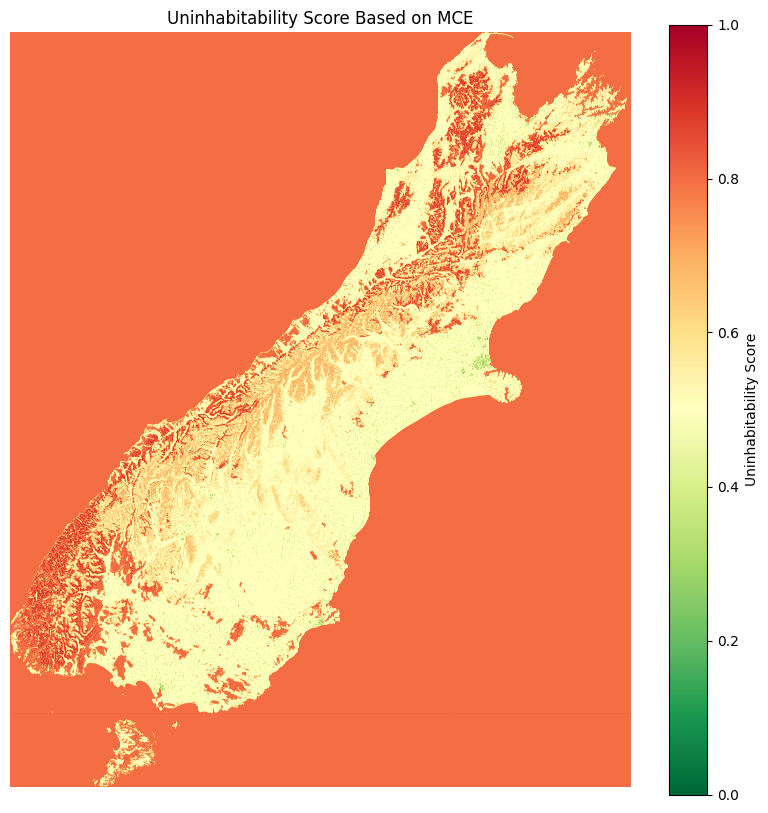

In [31]:
# Create a figure and plot the uninhabitability score as a continuous scale
plt.figure(figsize=(10, 10))

# Use imshow with a continuous color map (like a heatmap)
im = plt.imshow(uninhabitability_score, cmap='RdYlGn_r')  # 'RdYlGn_r' for reversed red to green

# Set the title for the plot
plt.title("Uninhabitability Score Based on MCE")

# Add a color bar to represent the score
cbar = plt.colorbar(im)
cbar.set_label('Uninhabitability Score')

# Turn off axis to clean the plot
plt.axis('off')

# Show the plot
plt.show()